In [1]:
import numpy as np
import torch
import torch.nn as nn
from basic_model import DeepModel_single, gradients
from visual_data import matplotlib_vision

import time
from tqdm import trange
import matplotlib.pyplot as plt

#### 2d-Cavity 流动问题
求解 $u(x,y)$, $v(x,y)$, $p(x,y)$
$$
    u \frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} + \frac{\partial p}{\partial x}
     - (\frac{\partial^2 u}{\partial^2 x} + \frac{\partial^2 u}{\partial^2 y})/ Re = 0\\
         u \frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + \frac{\partial p}{\partial y}
     - (\frac{\partial^2 v}{\partial^2 x} + \frac{\partial^2 v}{\partial^2 y})/ Re = 0\\
    u(x, 1) = 0, u(x, 0) = 0, u(0, y) = 0, u(1, y) = u_0\\
    v(x, 1) = v(x, 0) = v(0, y) =  v(1, y) = 0\\
    Re = 100.
$$

In [8]:
class Net(DeepModel_single):
    def __init__(self, planes):
        super(Net, self).__init__(planes, active=nn.Tanh())
        self.Re = 100.


    def equation(self, inn_var, out_var):
        p = out_var[..., (0,)]
        u = out_var[..., (1,)]
        v = out_var[..., (2,)]
        dpda = gradients(p, inn_var)
        duda = gradients(u, inn_var)
        dvda = gradients(v, inn_var)

        dpdx, dpdy = dpda[..., (0,)], dpda[..., (1,)]
        dudx, dudy = duda[..., (0,)], duda[..., (1,)]
        dvdx, dvdy = dvda[..., (0,)], dvda[..., (1,)]

        d2udx2 = gradients(dudx, inn_var)[..., (0,)]
        d2udy2 = gradients(dudy, inn_var)[..., (1,)]
        d2vdx2 = gradients(dvdx, inn_var)[..., (0,)]
        d2vdy2 = gradients(dvdy, inn_var)[..., (1,)]

        res_x = u * dudx + v * dudy + dpdx - (d2udx2+d2udy2) / self.Re
        res_y = u * dvdx + v * dvdy + dpdy - (d2vdx2+d2vdy2) / self.Re
        res_c = dudx + dvdy

        return torch.cat((res_x, res_y, res_c), dim=-1)

#### 数据生成

Text(0, 0.5, '$y$')

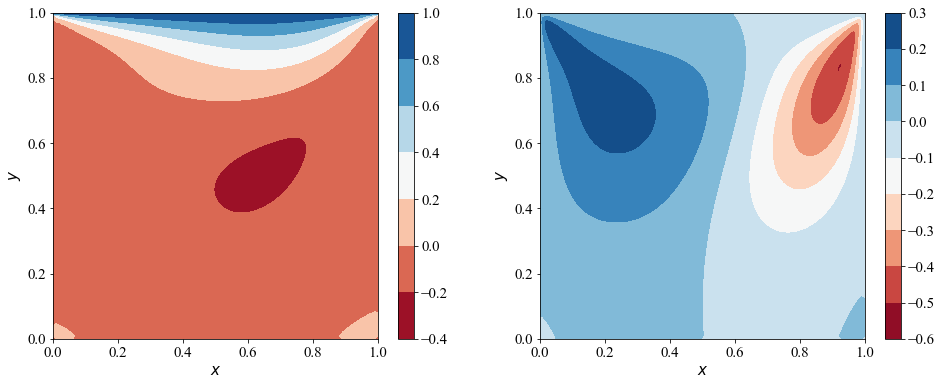

In [27]:
Nx = 100
Ny = 100  # change to 100
node_x = np.linspace(0.0, 1.0, Nx)[:, None]
node_y = np.linspace(0.0, 1.0, Ny)[:, None]
node_x = np.tile(node_x, (1, node_y.shape[0]))  # Nx x Ny
node_y = np.tile(node_y, (1, node_x.shape[0])).T  # Nx x Ny

U = np.genfromtxt("data\\cavity\\reference_u.csv", delimiter=',')
V = np.genfromtxt("data\\cavity\\reference_v.csv", delimiter=',')

input = np.stack((node_x, node_y), axis=-1)
field = np.stack((np.zeros_like(U), U, V), axis=-1).astype(np.float32)
# print(field.shape)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

nodes_train = torch.tensor(input, dtype=torch.float32).to(device)
field_train = torch.tensor(field, dtype=torch.float32).to(device)

plt.figure(figsize=(16, 6))
plt.clf()
plt.subplot(121)
plt.contourf(node_x, node_y, field[..., 1], cmap='RdBu')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.subplot(122)
plt.contourf(node_x, node_y, field[..., 2], cmap='RdBu')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')

#### 定义训练过程

In [10]:
# 建立网络
Net_model = Net(planes=[2] + [64] * 3 + [3],).to(device)
# 损失函数
L2loss = nn.MSELoss()
# 优化算法
Optimizer = torch.optim.Adam(Net_model.parameters(), lr=0.002, betas=(0.7, 0.9))
# 下降策略
Scheduler = torch.optim.lr_scheduler.MultiStepLR(Optimizer, milestones=[70000, 90000, 100000], gamma=0.1)
# 可视化
Visual = matplotlib_vision('/', input_name=('x', 'y'), field_name=('p','u','v',))
def train(inn_var, bounds, out_true, model, Loss, optimizer, scheduler, log_loss):

    def closure():

        optimizer.zero_grad()
        out_var = model(inn_var)
        res_i = model.equation(inn_var, out_var)
        bcs_loss_l11 = Loss(out_var[0, :, 1:], out_true[0, :, 1:])
        bcs_loss_l21 = Loss(out_var[-1, :, 1:], out_true[-1, :, 1:])
        bcs_loss_l12 = Loss(out_var[:, 0, :], out_true[:, 0, :])
        bcs_loss_l22 = Loss(out_var[:, -1, 1:], out_true[:, -1, 1:])
        eqs_loss = Loss(res_i, torch.zeros_like(res_i, dtype=torch.float32))
        bcs_loss = bcs_loss_l11 + bcs_loss_l21 + bcs_loss_l12 + bcs_loss_l22
        loss_batch = bcs_loss + eqs_loss
        loss_batch.backward()

        data_loss = Loss(out_var, out_true)
        log_loss.append([eqs_loss.item(), bcs_loss.item(), data_loss.item()])

        return loss_batch

    optimizer.step(closure)
    scheduler.step()

def inference(inn_var, model):

    out_pred = model(inn_var)
    equation = model.equation(inn_var, out_pred)
    return out_pred, equation

#### 执行训练过程

In [12]:
star_time = time.time()
log_loss = []
pbar = trange(100000)

inn_var = nodes_train
inn_var.requires_grad_(True)

# Training
for iter in pbar:

    learning_rate = Optimizer.state_dict()['param_groups'][0]['lr']
    train(inn_var, [], field_train, Net_model, L2loss, Optimizer, Scheduler, log_loss)

    # if iter > 0 and iter % 200 == 0:
    # print('iter: {:6d}, lr: {:.3e}, eqs_loss: {:.3e}, dat_loss: {:.3e}, bon_loss1: {:.3e}, cost: {:.2f}'.
    #       format(iter, learning_rate, log_loss[-1][0], log_loss[-1][-1], log_loss[-1][1], time.time()-star_time))

    pbar.set_postfix({'lr': learning_rate, 'dat_loss': log_loss[-1][-1], 'cost:':  time.time()-star_time,
                      'eqs_loss': log_loss[-1][0], 'bcs_loss': log_loss[-1][1], })

100%|██████████| 100000/100000 [25:22<00:00, 65.68it/s, lr=2e-5, dat_loss=0.00247, cost:=1.52e+3, eqs_loss=0.000216, bcs_loss=0.000758] 


#### 训练过程损失可视化

Text(0.5, 1.0, 'training loss')

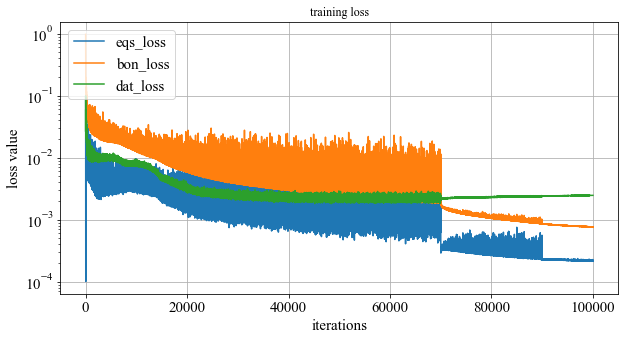

In [13]:
plt.figure(2, figsize=(10, 5))
plt.clf()
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 0], 'eqs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 1], 'bon_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, -1], 'dat_loss')
plt.title('training loss')

#### 结果对比

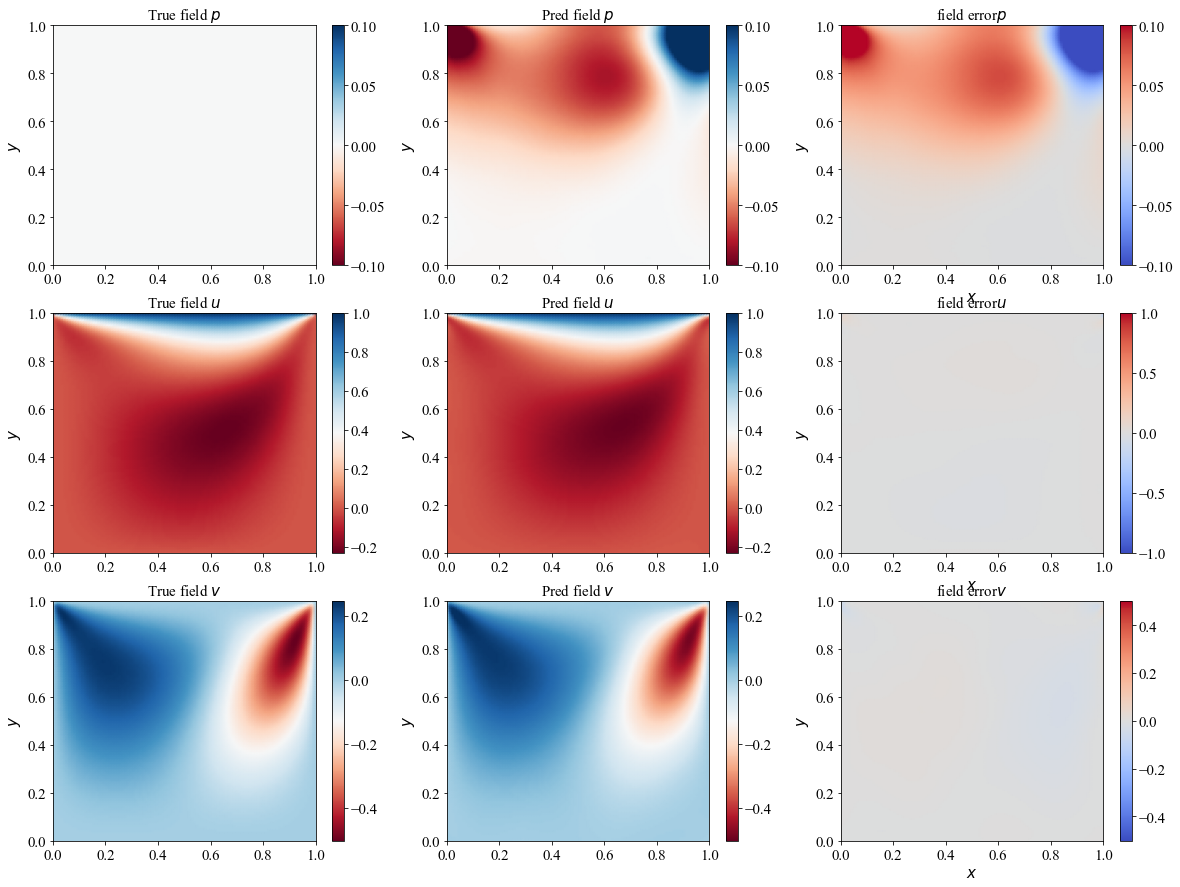

In [20]:
field_pred, equation = inference(inn_var, Net_model)

input_visual = input
field_visual_t = field
field_visual_p = field_pred.detach().cpu().numpy()

fig = plt.figure(figsize=(20, 15))
Visual.plot_fields_ms(field_visual_t, field_visual_p, input_visual)

#### 残差损失

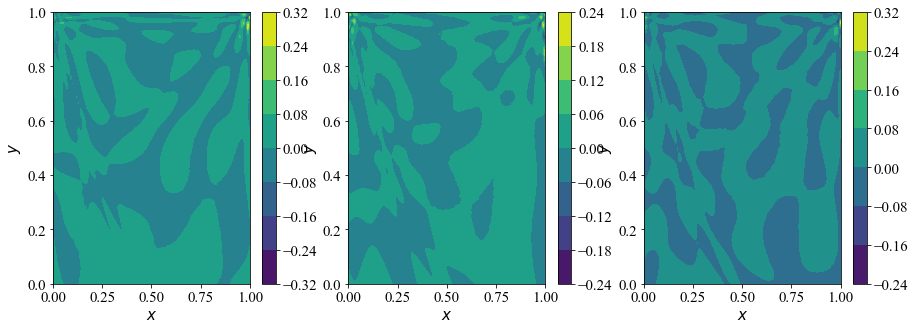

In [23]:
plt.figure(1, figsize=(15, 5))
plt.clf()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.contourf(input_visual[..., 0], input_visual[..., 1], equation[..., i].detach().cpu().numpy())
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.axis()
    plt.colorbar()


#### 细节对比

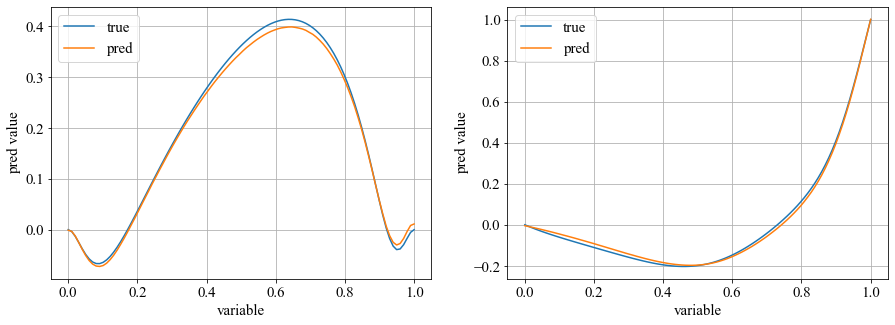

In [24]:
plt.figure(2, figsize=(15, 5))
plt.clf()
plt.subplot(121)
Visual.plot_value(input_visual[:, 88, 0], field_visual_t[:, 88, 1], 'true')
Visual.plot_value(input_visual[:, 88, 0], field_visual_p[:, 88, 1], 'pred')

plt.subplot(122)
Visual.plot_value(input_visual[50, :, 1], field_visual_t[50, :, 1], 'true')
Visual.plot_value(input_visual[50, :, 1], field_visual_p[50, :, 1], 'pred')